### Data Analysis on Multi-family Low-rise Buildings in NYC - Manhattan Community Board 3

In [1]:
import numpy as np
import pandas as pd
import math

from numpy import mean, std, cov, sqrt, log, sum
from numpy.random import seed

from datetime import date, timedelta, datetime

from random import sample

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from matplotlib_venn import venn2

import json
import requests
from bs4 import BeautifulSoup

from  scrapy.http import Request
from scrapy.selector import Selector
from scrapy.http import HtmlResponse

from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from tabulate import tabulate


import warnings
warnings.filterwarnings('ignore')

# style.use('fivethirtyeight')

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 1000)

rand_state=1000

### Import Data

#### The basic information of buildings in Manhattan Community Board 3 are from Pluto Data Dictionary from new york city public databases.

The information might be incomplete. An alternative way is to ask for information from new york city's office or Community Board 3.

In [2]:
## https://www1.nyc.gov/assets/planning/download/pdf/data-maps/open-data/pluto_datadictionary.pdf?v=22v1
raw_pluto=pd.read_csv('data/pluto_22v1.csv')

# building class codes
raw_buildingclass=pd.read_csv('data/buildingclasscode.csv')

# owner type codes
raw_ownertype=pd.read_csv('data/ownertype.csv')


### Data merging and cleansing

In [3]:
## imputate yearbuilt of value 0
pluto=raw_pluto[(raw_pluto['landuse'].isin([2,3])) &
         (raw_pluto['cd']==303.0) &
         (raw_pluto['bldgdepth']<75)]

pluto=pluto[['bbl','yearbuilt','lot','ownertype', 'ownername',
             'bldgclass','address','assesstot','exempttot', 
             'latitude', 'longitude', 'unitstotal']]
pluto['bbl'] = pluto['bbl'].round().apply(int).apply(str)

pluto=pluto.merge(raw_buildingclass, left_on='bldgclass', right_on='id', how='left').drop('id',axis=1)

def replace_missing(val, probs):
    if (np.isnan(val)) | (val<=1):
        return np.random.choice(probs.index, p = probs)
    else:
        return val
    
for col in ["yearbuilt"]:
    # get weights of unique values
    unique_p = pluto[col].value_counts(normalize = True)
    # apply function above
    pluto[col] = pluto[col].apply(replace_missing, args = (unique_p,))

## change ownertype to Private('P') if it is NaN 
pluto['ownertype'].fillna('P', inplace=True)
pluto=pluto.merge(raw_ownertype, left_on='ownertype', right_on='id', how='left').drop('id',axis=1)

## calculate property values, ages, taxes etc
pluto['property_value']=pluto['assesstot']-pluto['exempttot']
pluto['age']=date.today().year-pluto['yearbuilt']
pluto['tax_rate']=np.where(pluto['unitstotal']<=3, 0.19963, 0.12235)
pluto['tax']=pluto['property_value']*pluto['tax_rate']


### Question 1: How many multi-family low-rise buildings are sited in NYC - Manhattan Community Board 3?

- 6106

In [7]:
print('The number of low rise multiple family buildings in Manhattan Community Board 3 is :', len(pluto))

The number of low rise multiple family buildings in Manhattan Community Board 3 is : 6106


Text(0.5, 1.0, 'Low rise multi-family buildings in Manhattan CB 3')

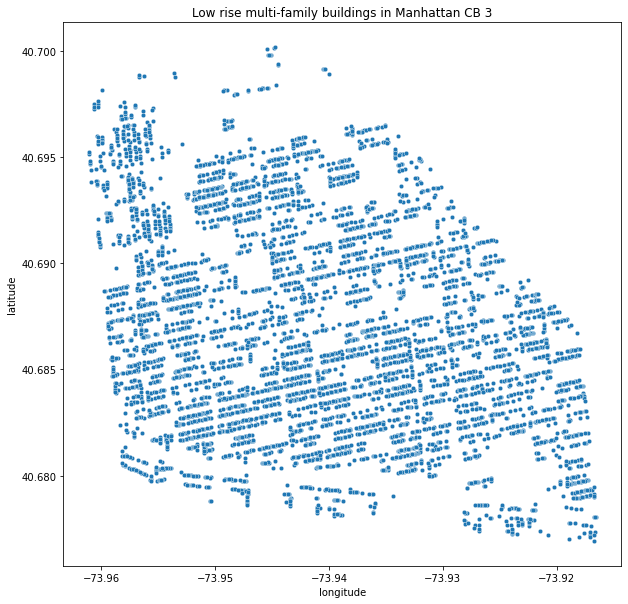

In [8]:
plt.figure(figsize=(10,10))
sns.scatterplot(x='longitude', y='latitude', s=20, data=pluto)
plt.title('Low rise multi-family buildings in Manhattan CB 3')

### Question 2: Building Age

In [9]:
pluto[['bbl','yearbuilt','age']].sort_values(by='age')

,bbl,yearbuilt,age
3468,3015570038,2021.0,1.0
1246,3016570018,2021.0,1.0
3875,3016420006,2021.0,1.0
1336,3018060030,2021.0,1.0
4459,3018220101,2021.0,1.0
...,...,...,...
4040,3016690065,1872.0,150.0
4098,3016790037,1871.0,151.0
2343,3018180037,1871.0,151.0
868,3018520012,1863.0,159.0


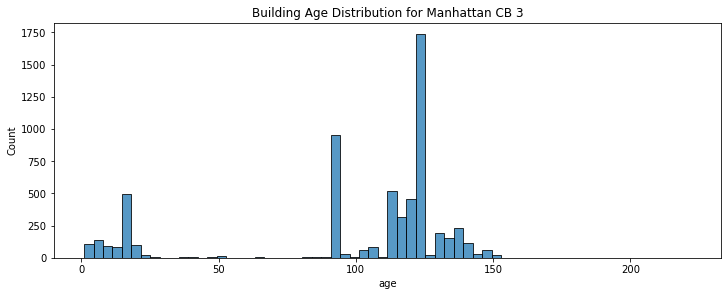

In [10]:
df=pluto[['bbl', 'age']]
fig = plt.figure(constrained_layout=True, figsize=(10,4))
ax=sns.histplot(x="age", data=df)
plt.title('Building Age Distribution for Manhattan CB 3')
plt.show()

Text(0.5, 1.0, 'Low rise multi-family buildings in Manhattan CB 3 (by Age)')

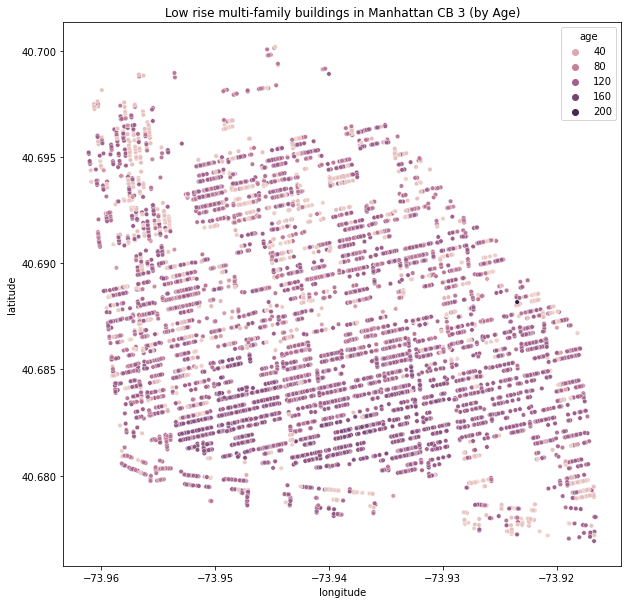

In [11]:
plt.figure(figsize=(10,10))
sns.scatterplot(x='longitude', hue='age', y='latitude', s=20, data=pluto)
plt.title('Low rise multi-family buildings in Manhattan CB 3 (by Age)')

###  Question 2: Property taxes

In [12]:
pluto[['bbl','assesstot','exempttot','property_value','tax']].sort_values(by='property_value')

,bbl,assesstot,exempttot,property_value,tax
908,3017600053,161100.0,161100.0,0.0,0.00000
605,3016470019,315000.0,315000.0,0.0,0.00000
3401,3016510045,92160.0,92160.0,0.0,0.00000
4422,3018150014,432450.0,432450.0,0.0,0.00000
5479,3020170001,270450.0,270450.0,0.0,0.00000
...,...,...,...,...,...
2101,3017780089,3347100.0,0.0,3347100.0,409517.68500
1880,3019940007,3666150.0,0.0,3666150.0,448553.45250
47,3019247501,5579559.0,9840.0,5569719.0,681455.11965
3929,3016330060,6010200.0,0.0,6010200.0,735347.97000


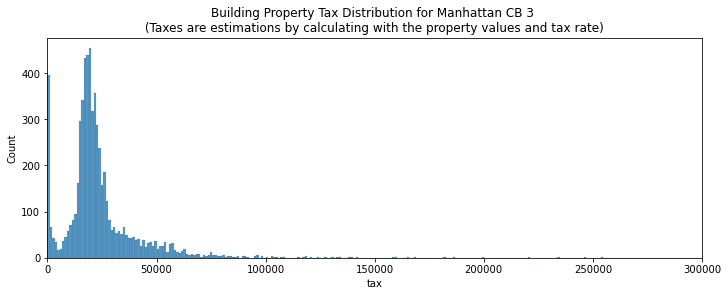

In [38]:
df=pluto[['bbl', 'tax']]
fig = plt.figure(constrained_layout=True, figsize=(10,4))
ax=sns.histplot(x="tax", data=df)
plt.title('Building Property Tax Distribution for Manhattan CB 3 \n (Taxes are estimations by calculating with the property values and tax rate) ')
plt.xlim([-50, 300000])
plt.show()

Text(0.5, 1.0, 'Low rise multi-family buildings in Manhattan CB 3 (by Tax)')

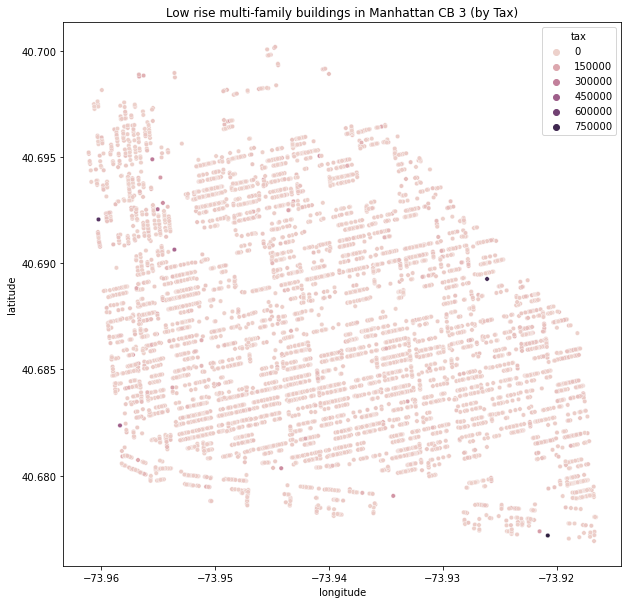

In [14]:
plt.figure(figsize=(10,10))
sns.scatterplot(x='longitude', hue='tax', y='latitude', s=20, data=pluto)
plt.title('Low rise multi-family buildings in Manhattan CB 3 (by Tax)')

### Ownership

In [15]:
pluto[['bbl','ownername', 'ownertype', 'owner_type']]

,bbl,ownername,ownertype,owner_type
0,3019680005,55-27 MYRTLE AVE REALTY GROUP LLC,P,Private ownership
1,3018160056,"PASTUIZACA, LUIS",P,Private ownership
2,3016670041,"SMITHSIMON, GREGORY",P,Private ownership
3,3017700095,"MALIK, MOSHE SHIMON",P,Private ownership
4,3018540009,"NOVELO, CLAUDIA",P,Private ownership
...,...,...,...,...
6101,3019740019,"THORPE, PAUL",P,Private ownership
6102,3019490007,UNAVAILABLE OWNER,P,Private ownership
6103,3017620026,BEDFORD REALTY HOLDINGS LLC,P,Private ownership
6104,3017130016,"RALPH-GATES CLUSTER, L.P.",X,Fully tax-exempt property that may be owned by...


### Question 2: Public or Private

In [59]:
pluto[['address', 'ownertype', 'owner_type']].head(20)

,address,ownertype,owner_type
0,351 FRANKLIN AVENUE,P,Private ownership
1,429 MONROE STREET,P,Private ownership
2,682 HALSEY STREET,P,Private ownership
3,5 PULASKI STREET,P,Private ownership
4,18 MAC DONOUGH STREET,P,Private ownership
5,110 MADISON STREET,P,Private ownership
6,47 HART STREET,P,Private ownership
7,21 VERNON AVENUE,P,Private ownership
8,316 THROOP AVENUE,P,Private ownership
9,643 MADISON STREET,P,Private ownership


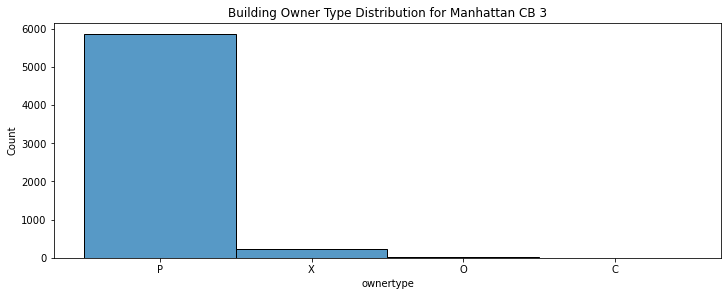

In [57]:
df=pluto[['address', 'ownertype']]
fig = plt.figure(constrained_layout=True, figsize=(10,4))
ax=sns.histplot(x="ownertype", data=df)
plt.title('Building Owner Type Distribution for Manhattan CB 3')
plt.show()

(-50.0, 300000.0)

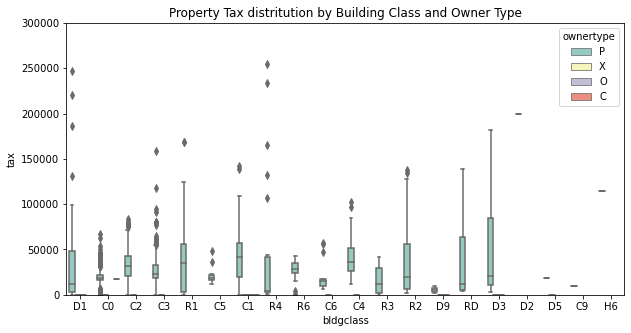

In [90]:
plt.figure(figsize=(10,5))

sns.boxplot(x="bldgclass", y="tax", hue="ownertype",
                 data=pluto, palette="Set3")
plt.title('Property Tax distritution by Building Class and Owner Type')
plt.ylim(-50, 300000)

Text(0.5, 1.0, 'Low rise multi-family building counts by Building Class and Owner Type')

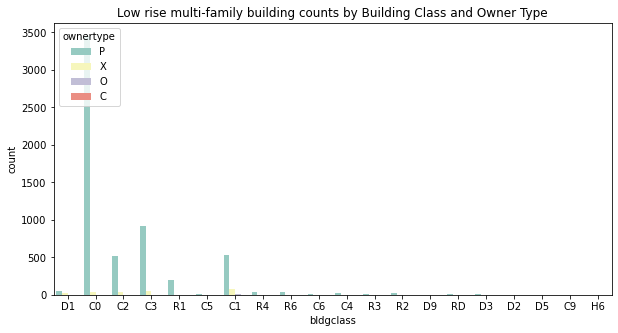

In [89]:
plt.figure(figsize=(10,5))

sns.countplot(x="bldgclass", hue="ownertype",
                 data=pluto, palette="Set3")
plt.title('Low rise multi-family building counts by Building Class and Owner Type')

Text(0.5, 1.0, 'Low rise multi-family buildings in Manhattan CB 3 (by Owner type)')

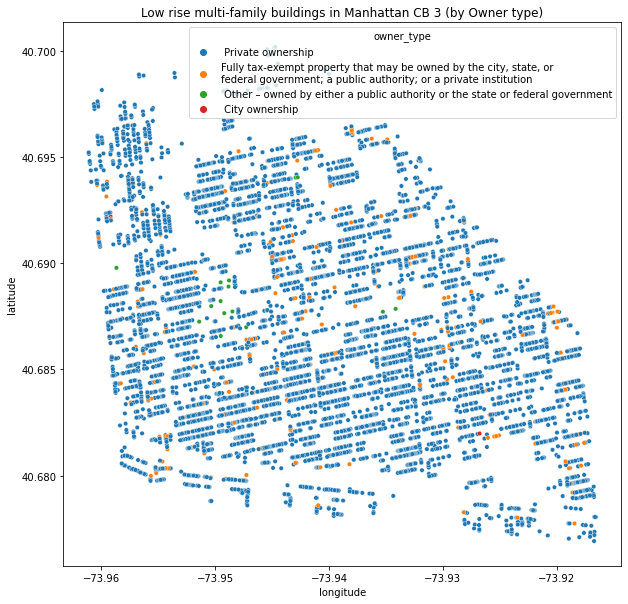

In [17]:
plt.figure(figsize=(10,10))
sns.scatterplot(x='longitude', hue='owner_type', y='latitude', s=20, data=pluto)
plt.title('Low rise multi-family buildings in Manhattan CB 3 (by Owner type)')

### Question 2: Rent control/stabilized, Co-op, Condo
- In general, rent stabilized buildings:
- Contain 6 or more units;
- Were built before 1974;
- Are not co-ops or condos;

#### In this analysis, these conditions above are supposed to be all inclusive to define a rent control/stabilized building


In [52]:
pluto['rent_stabilization']=np.where((pluto['unitstotal']>=6) 
                                     & (pluto['yearbuilt']<1974)
                                     & ~pluto['bldgclass'].str.startswith('R'), 'Rent Stabilization',pluto['building_class'] )

In [53]:
data=pluto[['address', 'age', 'ownername', 'bldgclass',
            'assesstot', 'exempttot', 'latitude', 'longitude', 'unitstotal', 
            'building_class', 'owner_type', 'rent_stabilization',
            'tax_rate', 'tax']]
data=data.rename(columns={"tax": "tax_calculated_by_rate"})
data.head(50)

,address,age,ownername,bldgclass,assesstot,exempttot,latitude,longitude,unitstotal,building_class,owner_type,rent_stabilization,tax_rate,tax_calculated_by_rate
0,351 FRANKLIN AVENUE,10.0,55-27 MYRTLE AVE REALTY GROUP LLC,D1,789300.0,0.0,40.687423,-73.956659,10.0,ELEVATOR APARTMENTS: Semi-fireproof (Without S...,Private ownership,ELEVATOR APARTMENTS: Semi-fireproof (Without S...,0.12235,96570.85500
1,429 MONROE STREET,16.0,"PASTUIZACA, LUIS",C0,76080.0,1440.0,40.686886,-73.940256,3.0,WALK UP APARTMENTS: Three Families,Private ownership,WALK UP APARTMENTS: Three Families,0.19963,14900.38320
2,682 HALSEY STREET,123.0,"SMITHSIMON, GREGORY",C0,82680.0,1440.0,40.684273,-73.926666,3.0,WALK UP APARTMENTS: Three Families,Private ownership,WALK UP APARTMENTS: Three Families,0.19963,16217.94120
3,5 PULASKI STREET,107.0,"MALIK, MOSHE SHIMON",C0,76740.0,0.0,40.692361,-73.951326,3.0,WALK UP APARTMENTS: Three Families,Private ownership,WALK UP APARTMENTS: Three Families,0.19963,15319.60620
4,18 MAC DONOUGH STREET,123.0,"NOVELO, CLAUDIA",C0,103860.0,0.0,40.680605,-73.945447,3.0,WALK UP APARTMENTS: Three Families,Private ownership,WALK UP APARTMENTS: Three Families,0.19963,20733.57180
5,110 MADISON STREET,117.0,"WILLIAMS, CHARLENE",C0,105540.0,0.0,40.683999,-73.954804,3.0,WALK UP APARTMENTS: Three Families,Private ownership,WALK UP APARTMENTS: Three Families,0.19963,21068.95020
6,47 HART STREET,123.0,MYRTLE G SPARKS,C0,95280.0,0.0,40.693228,-73.950305,3.0,WALK UP APARTMENTS: Three Families,Private ownership,WALK UP APARTMENTS: Three Families,0.19963,19020.74640
7,21 VERNON AVENUE,123.0,DAVID TUBIAN,C0,96300.0,0.0,40.694595,-73.951425,3.0,WALK UP APARTMENTS: Three Families,Private ownership,WALK UP APARTMENTS: Three Families,0.19963,19224.36900
8,316 THROOP AVENUE,17.0,AVON APARTMENTS LLC,C0,92460.0,0.0,40.693444,-73.943330,3.0,WALK UP APARTMENTS: Three Families,Private ownership,WALK UP APARTMENTS: Three Families,0.19963,18457.78980
9,643 MADISON STREET,7.0,MADISON PARK ESTATES LLC,C2,553050.0,533588.0,40.687147,-73.931491,6.0,WALK UP APARTMENTS: Five to Six Families,Private ownership,WALK UP APARTMENTS: Five to Six Families,0.12235,2381.17570


### Question 2: Market Rental and Energy Source

- the data are scraped from Zillow, seems zillow doesn't like people to scrape their data. So just a dozen or so buidlings' information were scraped before this process were interrupted by zillow.

In [78]:
def getproperties(prop, field):
    result=[]
    if field in prop:
        result= prop[field]
    return result
    
baseURL='https://www.zillow.com/homes/'

df=pd.DataFrame()
notdone=pd.DataFrame()
block=0

for i in range(len(pluto)):
# for i in range(1):
    url=baseURL+pluto['address'][i].replace(' ','-')+',-new-york'+'_rb'
    
    isGetlist=False
    
    zpid=''
    address=''
    price=0
    rental=0
    latest_tax=0
    heating='None'
    
    headers ={
        'authority': 'app.mybodygallery.com',
        'method': 'GET',
        'path': '/classes/Photo?where=%7B%22gender%22:%22female%22,%22status%22:%22APPROVED%22,%22weight%22:%7B%22$gte%22:47,%22$lte%22:53%7D%7D',
        'scheme': 'https',
        'accept': 'application/json, text/plain, */*',
        'accept-encoding': 'gzip, deflate, br',
        'accept-language': 'en-GB,en-US;q=0.9,en;q=0.8',
        'cache-control': 'no-cache',
        'pragma': 'no-cache',
        'referer': url,
        'sec-ch-ua': '" Not;A Brand";v="99", "Google Chrome";v="91", "Chromium";v="91"',
        'sec-ch-ua-mobile': '?1',
        'sec-fetch-dest': 'empty',
        'sec-fetch-mode': 'cors',
        'sec-fetch-site': 'same-origin',
        'user-agent': 'Mozilla/5.0 (Linux; Android 5.0; SM-G900P Build/LRX21T) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Mobile Safari/537.36'
    }
    
    content = requests.get(url,headers=headers)  
    soup = BeautifulSoup(content.text,"lxml")    
    
    item = soup.select_one("script#hdpApolloPreloadedData")    
    if item==None:
        print('not hdpApolloPreloadedData')
        d=soup.select_one("script#__NEXT_DATA__")
        if d==None:  
            print('not __NEXT_DATA__')
#             driver = webdriver.Chrome(executable_path='C:/chromedriver/chromedriver.exe',options=options)
#             driver.get(url)
#             soup = BeautifulSoup(driver.page_source, "html.parser")        
#             item = soup.select_one("script#hdpApolloPreloadedData")
#             driver.close()  
            notdone.append(pluto.iloc[i])
            isGetlist=True
        else:    
            item = json.loads(soup.select_one("script#__NEXT_DATA__").text)['props']
            properties=item['initialData']['building']
            zpid= getproperties(properties,"zpid")
            address = getproperties(properties,"fullAddress")
            units=getproperties(properties,"ungroupedUnits")
            price=0
            if units != []:
                for u in units:
                    if (getproperties(u,"price")!=[]) & (getproperties(u,"price")!=None):
                        price=price+getproperties(u,"price")
            rental    = 0              
            latest_tax=0     
            heating='None'
            isGetlist=True
            
    if not isGetlist:
        d = json.loads(item.text)['apiCache']
        data=json.loads(d)
        
        key1 = list(data.keys())[0]
        key2 = list(data.keys())[1]        
        
        properties1 = data[key1]["property"]
        properties2 = data[key2]["property"]

        zpid = getproperties(properties1,"zpid")
        
        address = getproperties(properties1,"streetAddress")+', ' \
            +getproperties(properties1,"city")+', ' \
            +getproperties(properties1,"state")+' ' \
            +getproperties(properties1,"zipcode")
        
        price = getproperties(properties1,"price")
        rental     = getproperties(properties1,"zestimate") 
        latest_tax=getproperties(properties2,"taxHistory")
        if latest_tax !=[]:
            latest_tax=latest_tax[0]['value']      
        heating='None'
        
        facts=[]
        resoFacts=getproperties(properties2,"resoFacts")
        if resoFacts !=[]:
            facts=getproperties(resoFacts,"atAGlanceFacts")
         
        for f in facts:
            if f['factLabel']=='Heating':
                heating=f['factValue']
                break
                
    listing={}
    listing['zpid']=zpid
    listing['address']=address
    listing['price']=price
    listing['rental']=rental
    listing['latest_tax']=latest_tax
    listing['heating']=heating
    if zpid=='':
        block=block+1
        if block==5:
              break;
    else:
        block=0
    
    df=df.append(listing, ignore_index=True)

#### the Market Rental and Energy information scraped before blocked by zillow

In [23]:
df

,zpid,address,price,rental,latest_tax,heating
0,2080394018,"351 Franklin Ave, Brooklyn, NY 11238",7440300.0,0.0,0.0,None
1,72700182,"429 Monroe St, Brooklyn, NY 11221",1586100.0,4795.0,83400.0,None
2,30605179,"682 Halsey St, Brooklyn, NY 11233",1462000.0,0.0,0.0,None
3,31596990,"5 Pulaski St, New York Mills, NY 13417",195700.0,1669.0,84000.0,"Gas, Forced Air"
4,2080586673,"181 Mac Donough St UNIT 3, Brooklyn, NY 11216",987400.0,2232.0,[],None
5,2094119781,"110 Madison St APT 16, New York, NY 10002",[],2796.0,[],None
6,2099239579,"47 New Hartford St, New York Mills, NY 13417",180900,1669.0,[],None
7,2062586377,"21 Union Ave FLOOR 3, Mount Vernon, NY 10550",2900,[],[],None
8,83049783,"316 Throop Ave, Brooklyn, NY 11206",847200,0,0,None
9,30603750,"643 Madison St, Brooklyn, NY 11221",10658000,0,0,None


#### Fuel Cost and emission information from the new york city public database are limited. And I haven't got a second source for those information yet. 